# Clustering Notebook
Using the gathered dataset from OpenStreetMap and the "Computer Vision" dataset, the following methods will be conducted:
1. Merging the two datasets
2. Data preparation
3. Clustering Analysis via K-Means

In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "6" 

# Avoid memory leak for KMeans

In [2]:
import geopandas as gpd
import pandas as pd
import osmnx
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, RobustScaler, PowerTransformer
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import silhouette_score

import ast

In [3]:
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
# pd.set_option('display.width', 1000)

In [74]:
gdf_edge_bike = gpd.read_file('geofabrik_merged_data (tentative)/geofabrik_bike_graph_edges_w_EDSAaccidents.geojson')
gdf_edge_walk = gpd.read_file('geofabrik_merged_data (tentative)/geofabrik_walk_graph_edges_w_EDSAaccidents.geojson') 
image_df = pd.read_csv('final_image_processing.csv')

# Merging the two datasets
1. Drop columns that have at least 50% missing data.
2. Choose relevant features
3. Merge with "Computer Vision" dataset

## Bikeability

In [75]:
gdf_edge_bike.shape

(16166, 164)

In [76]:
gdf_edge_bike.drop(gdf_edge_bike.columns[gdf_edge_bike.isnull().mean()>0.5], axis=1, inplace=True)

In [77]:
gdf_edge_bike.columns

Index(['u', 'v', 'key', 'highway', 'lit', 'name', 'surface', 'osmid',
       'timestamp', 'version', 'tags', 'osm_type', 'length', 'TAG_visible',
       'HAS_TAG', 'geometry'],
      dtype='object')

In [78]:
bike_features = [
    'u', 'v', 
    'key', 
    'highway', 'lit', 
    # 'name',
    'surface', 
    # 'osmid',
     # 'timestamp', 'version', 'tags', 'osm_type',
    'length', 
    # 'TAG_visible', 'HAS_TAG', 
    'geometry',
]

gdf_edge_bike = gdf_edge_bike[bike_features]

In [79]:
gdf_lines = gdf_edge_bike
gdf_lines['ID'] = gdf_lines['u'].astype(str) + '_' + gdf_lines['v'].astype(str) + '_' + gdf_lines['key'].astype(str)
gdf_points = gpd.GeoDataFrame(image_df, geometry=gpd.points_from_xy(image_df.longitude, image_df.latitude))

In [80]:
gdf_lines.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [81]:
gdf_points = gdf_points.set_crs('EPSG:4326')
gdf_points.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [82]:
joined_bike = gpd.sjoin_nearest(gdf_points, gdf_lines, how='inner') # Ignore warning, topography doesn't matter in this context

C:\Users\USER\.conda\envs\recweek_email_new\lib\site-packages\geopandas\array.py:365: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


In [83]:
joined_bike.shape

(5562, 53)

In [84]:
joined_bike.ID.nunique()

1514

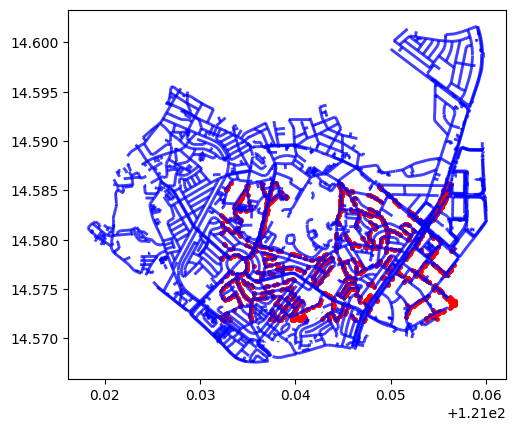

In [85]:
fig, ax = plt.subplots()
gdf_lines.plot(ax=ax, color='blue', linewidth=2, alpha=0.5)
joined_bike.plot(ax=ax, color='red', markersize=5)
plt.show()

In [86]:
joined_bike.columns

Index(['image_id', 'latitude', 'longitude', 'scene_label', 'elements_present',
       'road_condition', 'traffic_objects', 'general_objects', 'unlabeled',
       'flat-road', 'flat-sidewalk', 'flat-crosswalk', 'flat-cyclinglane',
       'flat-parkingdriveway', 'flat-railtrack', 'flat-curb', 'human-person',
       'human-rider', 'vehicle-car', 'vehicle-truck', 'vehicle-bus',
       'vehicle-tramtrain', 'vehicle-motorcycle', 'vehicle-bicycle',
       'vehicle-caravan', 'vehicle-cartrailer', 'construction-building',
       'construction-door', 'construction-wall', 'construction-fenceguardrail',
       'construction-bridge', 'construction-tunnel', 'construction-stairs',
       'object-pole', 'object-trafficsign', 'object-trafficlight',
       'nature-vegetation', 'nature-terrain', 'sky', 'void-ground',
       'void-dynamic', 'void-static', 'void-unclear', 'geometry',
       'index_right', 'u', 'v', 'key', 'highway', 'lit', 'surface', 'length',
       'ID'],
      dtype='object')

In [87]:
def aggregate_lists(series):
    aggregated_set = set()
    
    for item in series:
        # Convert the string representation of the list to an actual list
        evaluated_list = ast.literal_eval(item)
        # Update the set with elements from the evaluated list
        aggregated_set.update(evaluated_list)
    
    return list(aggregated_set)

mean_columns = ['unlabeled',
       'flat-road', 'flat-sidewalk', 'flat-crosswalk', 'flat-cyclinglane',
       'flat-parkingdriveway', 'flat-railtrack', 'flat-curb', 'human-person',
       'human-rider', 'vehicle-car', 'vehicle-truck', 'vehicle-bus',
       'vehicle-tramtrain', 'vehicle-motorcycle', 'vehicle-bicycle',
       'vehicle-caravan', 'vehicle-cartrailer', 'construction-building',
       'construction-door', 'construction-wall', 'construction-fenceguardrail',
       'construction-bridge', 'construction-tunnel', 'construction-stairs',
       'object-pole', 'object-trafficsign', 'object-trafficlight',
       'nature-vegetation', 'nature-terrain', 'sky', 'void-ground',
       'void-dynamic', 'void-static', 'void-unclear',
        'length']
mode_columns = ['scene_label', 'road_condition', 'highway', 'surface', 'lit', 'u', 'v', 'key']
union_columns = ['traffic_objects', 'general_objects']

agg_dict = {col: 'mean' for col in mean_columns}
# agg_dict.update({col: lambda x: x.mode()[0] for col in mode_columns})
agg_dict.update({col: lambda x: x.mode()[0] if not x.mode().empty else None for col in mode_columns})
agg_dict.update({col: aggregate_lists for col in union_columns})

In [88]:
grouped_bike = joined_bike.groupby('ID').agg(agg_dict).reset_index()

## Walkability

In [89]:
gdf_edge_walk.shape

(16046, 164)

In [90]:
gdf_edge_walk.drop(gdf_edge_walk.columns[gdf_edge_walk.isnull().mean()>0.5], axis=1, inplace=True)

In [91]:
gdf_edge_walk.columns

Index(['u', 'v', 'key', 'highway', 'name', 'surface', 'osmid', 'timestamp',
       'version', 'tags', 'osm_type', 'length', 'TAG_visible', 'HAS_TAG',
       'geometry'],
      dtype='object')

In [92]:
walk_features = [
    'u', 'v', 
    'key', 
    'highway',
    # 'lit', 
    # 'name',
    'surface', 
    # 'osmid',
     # 'timestamp', 'version', 'tags', 'osm_type',
    'length', 
    # 'TAG_visible', 'HAS_TAG', 
    'geometry',
]

gdf_edge_walk = gdf_edge_walk[walk_features]

In [93]:
gdf_lines = gdf_edge_walk
gdf_lines['ID'] = gdf_lines['u'].astype(str) + '_' + gdf_lines['v'].astype(str) + '_' + gdf_lines['key'].astype(str)
gdf_points = gpd.GeoDataFrame(image_df, geometry=gpd.points_from_xy(image_df.longitude, image_df.latitude))

In [94]:
gdf_lines.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [95]:
gdf_points = gdf_points.set_crs('EPSG:4326')
gdf_points.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [96]:
joined_walk = gpd.sjoin_nearest(gdf_points, gdf_lines, how='inner') # Ignore warning, topography doesn't matter in this context

C:\Users\USER\.conda\envs\recweek_email_new\lib\site-packages\geopandas\array.py:365: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


In [97]:
joined_walk.shape

(5578, 52)

In [98]:
joined_walk.ID.nunique()

1530

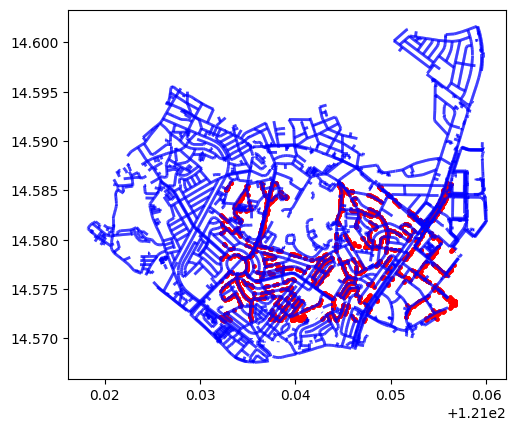

In [99]:
fig, ax = plt.subplots()
gdf_lines.plot(ax=ax, color='blue', linewidth=2, alpha=0.5)
joined_walk.plot(ax=ax, color='red', markersize=5)
plt.show()

In [100]:
joined_walk.columns

Index(['image_id', 'latitude', 'longitude', 'scene_label', 'elements_present',
       'road_condition', 'traffic_objects', 'general_objects', 'unlabeled',
       'flat-road', 'flat-sidewalk', 'flat-crosswalk', 'flat-cyclinglane',
       'flat-parkingdriveway', 'flat-railtrack', 'flat-curb', 'human-person',
       'human-rider', 'vehicle-car', 'vehicle-truck', 'vehicle-bus',
       'vehicle-tramtrain', 'vehicle-motorcycle', 'vehicle-bicycle',
       'vehicle-caravan', 'vehicle-cartrailer', 'construction-building',
       'construction-door', 'construction-wall', 'construction-fenceguardrail',
       'construction-bridge', 'construction-tunnel', 'construction-stairs',
       'object-pole', 'object-trafficsign', 'object-trafficlight',
       'nature-vegetation', 'nature-terrain', 'sky', 'void-ground',
       'void-dynamic', 'void-static', 'void-unclear', 'geometry',
       'index_right', 'u', 'v', 'key', 'highway', 'surface', 'length', 'ID'],
      dtype='object')

In [101]:
mean_columns = ['unlabeled',
       'flat-road', 'flat-sidewalk', 'flat-crosswalk', 'flat-cyclinglane',
       'flat-parkingdriveway', 'flat-railtrack', 'flat-curb', 'human-person',
       'human-rider', 'vehicle-car', 'vehicle-truck', 'vehicle-bus',
       'vehicle-tramtrain', 'vehicle-motorcycle', 'vehicle-bicycle',
       'vehicle-caravan', 'vehicle-cartrailer', 'construction-building',
       'construction-door', 'construction-wall', 'construction-fenceguardrail',
       'construction-bridge', 'construction-tunnel', 'construction-stairs',
       'object-pole', 'object-trafficsign', 'object-trafficlight',
       'nature-vegetation', 'nature-terrain', 'sky', 'void-ground',
       'void-dynamic', 'void-static', 'void-unclear',
        'length']
mode_columns = ['scene_label', 'road_condition', 'highway', 'surface', 'u', 'v', 'key']
union_columns = ['traffic_objects', 'general_objects']

agg_dict = {col: 'mean' for col in mean_columns}
# agg_dict.update({col: lambda x: x.mode()[0] for col in mode_columns})
agg_dict.update({col: lambda x: x.mode()[0] if not x.mode().empty else None for col in mode_columns})
agg_dict.update({col: aggregate_lists for col in union_columns})

In [102]:
grouped_walk = joined_walk.groupby('ID').agg(agg_dict).reset_index()

# Data Preparation

In [103]:
# Create metrics

def create_multiple_columns(row, use_lit):
    default_value = 0.5

    # Computer Vision
    has_crosswalk = 0 if row['scene_label'] == 'crosswalk' or 'crosswalks' in row['traffic_objects'] or row['flat-crosswalk'] >= 0.01 else 1

    has_traffic_sign = 0 if row['object-trafficsign'] >= 0.01 else 1
    
    has_traffic_light = 0 if row['object-trafficsign'] >= 0.01 or 'traffic lights' in row['traffic_objects'] or 'traffic light' in row['general_objects'] else 1

    has_bicycle = 0 if row['vehicle-bicycle'] >= 0.01 or 'bicycles' in row['traffic_objects'] or 'bicycle' in row['general_objects'] else 1

    total = 1 - (row['void-ground'] + row['void-static'] + row['void-dynamic'] + row['void-unclear'])
    flats = row['flat-road'] + row['flat-cyclinglane'] + row['flat-sidewalk'] + row['flat-crosswalk']

    obstruction_density = 1 - (flats/total)

    sidewalk_ratio = 1 - (row['flat-sidewalk']/flats) if flats > 0 else default_value

    cycling_lane_coverage = 1 - (row['flat-cyclinglane']/row['flat-road']) if row['flat-road'] > 0 else default_value
    cycling_lane_coverage = 1 if cycling_lane_coverage < 0 else cycling_lane_coverage

    greenery_ratio = 1 - ((row['nature-vegetation'] + row['nature-terrain'])/total)

    road_condition = 0 if row['road_condition'] == 'good' else 1

    # To return
    values = {'has_crosswalk' : has_crosswalk,
        'has_traffic_sign' : has_traffic_sign,
        'has_traffic_light' : has_traffic_light,
        'has_bicycle' : has_bicycle,
        'obstruction_density' : obstruction_density,
        'sidewalk_ratio' : sidewalk_ratio,
        'cycling_lane_coverage' : cycling_lane_coverage,
        'greenery_ratio' : greenery_ratio,
        'road_condition' : road_condition}
  
    # OpenStreetMap Data
    if use_lit:
        if isinstance(row['lit'], str):
            has_lit = 0 if row['lit'] == 'yes' else 1
        else:
            has_lit = 1
        values['has_lit'] = has_lit
        return pd.Series(values)
    else:
        return pd.Series(values)


In [104]:
metrics = 'has_crosswalk has_traffic_sign has_traffic_light has_bicycle obstruction_density sidewalk_ratio cycling_lane_coverage greenery_ratio road_condition'.split(' ')
grouped_bike[metrics + ['has_lit']] = grouped_bike.apply(lambda x: create_multiple_columns(x, use_lit=True), axis=1)
grouped_walk[metrics] = grouped_walk.apply(lambda x: create_multiple_columns(x, use_lit=False), axis=1)

In [133]:
# List down features
bike_cluster_features = metrics + 'has_lit scene_label highway surface'.split(' ')
walk_cluster_features = metrics + 'scene_label highway surface'.split(' ')

# Select features
df_bike = grouped_bike[bike_cluster_features]
df_walk = grouped_walk[walk_cluster_features]

# Keep identifiers
bike_ids = grouped_bike[['u', 'v', 'key']]
walk_ids = grouped_walk[['u', 'v', 'key']]

# Cluster Analysis

In [134]:
num_vars = 'obstruction_density sidewalk_ratio cycling_lane_coverage greenery_ratio'.split(' ')
cat_vars = 'scene_label highway surface'.split(' ')

In [135]:
# from migs cleaning file
def continuous_distributions(source, axes, title):
    for i, var in enumerate(num_vars):
        df = source.copy(deep = True)
        kde_scale_factor = (df[var].max() * 50)
        df[var] = df[var] / kde_scale_factor
        ax1 = axes[i]
        sns.histplot(df, x = var, ax = ax1, label = "Binned")
        sns.kdeplot(df, x = var, ax = ax1, color = "orange", label = "KDE (prob. density)")
        ax1.legend()
        ax1.set_xticks(ax1.get_xticks(),
                labels = (ax1.get_xticks() * kde_scale_factor).round(2))
        ax1.set_title(title)

## Bikeability

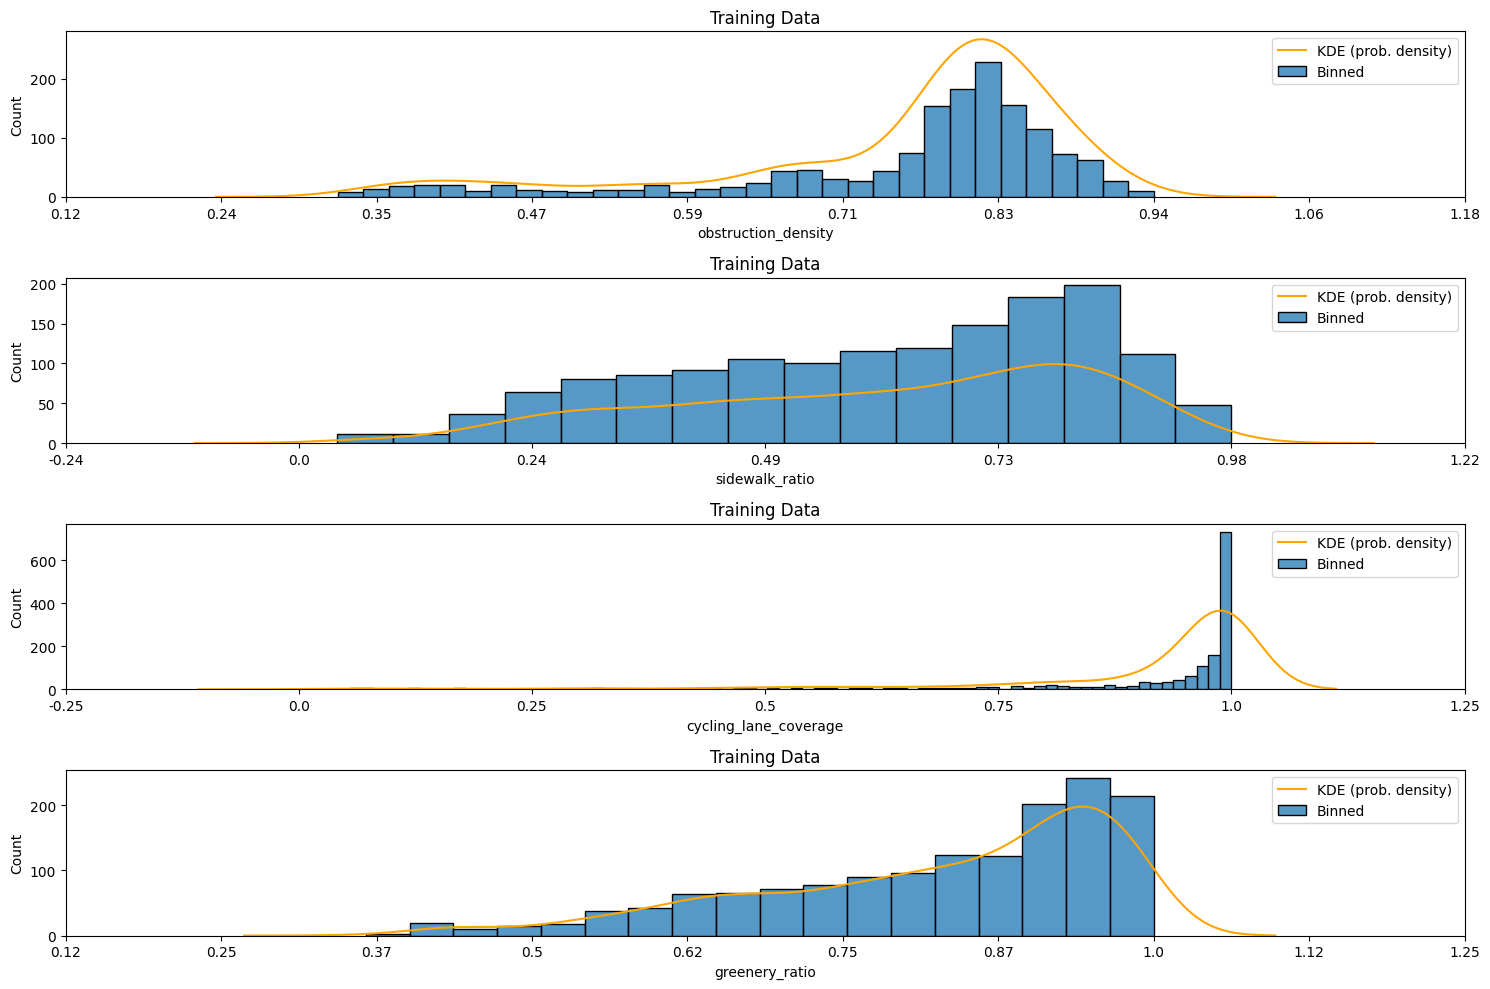

In [136]:
# Initial visualization
fig, axes = plt.subplots(len(num_vars), 1, figsize = (15, 10))
continuous_distributions(df_bike, axes[:], title = "Training Data")
plt.tight_layout()
plt.show()

- `obstruction_density` is right-skewed, will undergo log transformation
- `sidewalk_ratio` is relatively spread across the range, will be standardized
- `cycling_lane_coverage` is highly_skewed with a sharp peak close to 1, will use a RobustScaler
- `greenery_ratio` is right-skewed with a gradual increase, will undergo log transformation

In [137]:
df_bike_scaled = df_bike.copy()

In [138]:
# Scaling for continuous variables
df_bike_scaled['obstruction_density'] = np.log1p(df_bike['obstruction_density'])
df_bike_scaled['greenery_ratio'] = np.log1p(df_bike['greenery_ratio'])

standard_scaler = StandardScaler()
df_bike_scaled['sidewalk_ratio'] = standard_scaler.fit_transform(df_bike[['sidewalk_ratio']])

robust_scaler = RobustScaler()
df_bike_scaled['cycling_lane_coverage'] = robust_scaler.fit_transform(df_bike[['cycling_lane_coverage']])

In [139]:
# One-Hot Encoding for categorical columns, and scaling numerical features
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), cat_vars)  # One-Hot Encode categorical data
    ],
    remainder='passthrough'
)

# Step 2: Determine the optimal number of clusters using Elbow method and Silhouette Score
def find_optimal_clusters(X, max_k=10):
    inertias = []
    silhouette_scores = []

    for k in range(2, max_k + 1):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(X)
        inertias.append(kmeans.inertia_)
        silhouette_scores.append(silhouette_score(X, kmeans.labels_))

    # Plot the Elbow curve
    plt.figure(figsize=(10, 5))
    plt.plot(range(2, max_k + 1), inertias, marker='o')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Inertia')
    plt.title('Elbow Method for Optimal k')
    plt.show()

    # Plot the Silhouette Scores
    plt.figure(figsize=(10, 5))
    plt.plot(range(2, max_k + 1), silhouette_scores, marker='o', color='orange')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Score for Optimal k')
    plt.show()

    return inertias, silhouette_scores

# Step 3: Pipeline - Combining preprocessor and K-means
def perform_kmeans_clustering(df, n_clusters):
    pipeline = Pipeline(steps=[
        ('preprocessing', preprocessor),
        ('kmeans', KMeans(n_clusters=n_clusters, random_state=42))
    ])

    # Fit the pipeline to the data
    pipeline.fit(df)

    # Get the cluster labels
    labels = pipeline['kmeans'].labels_

    # Add the cluster labels to the original dataframe
    df['Cluster'] = labels

    return df, pipeline

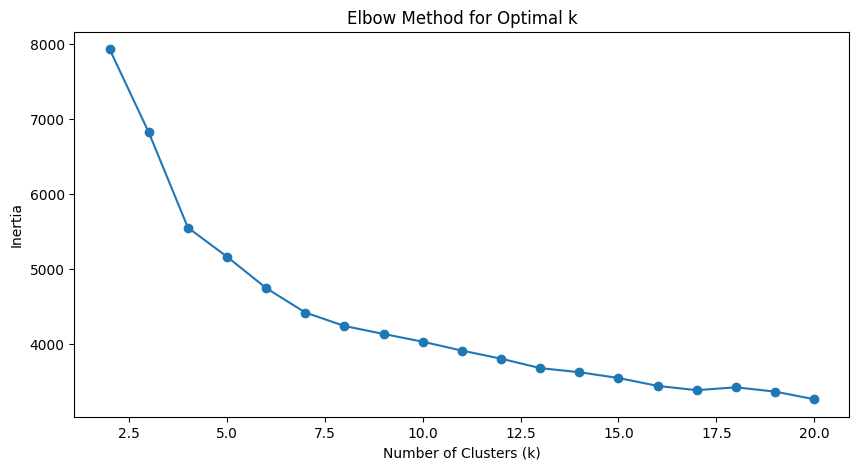

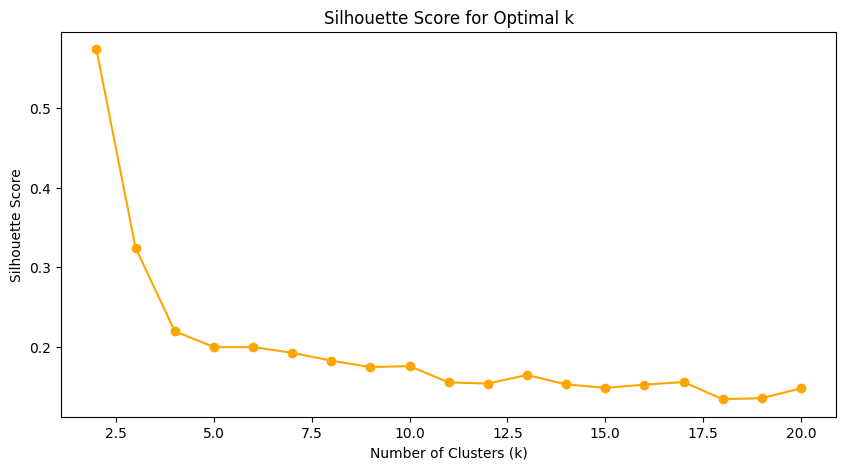

In [140]:
X = preprocessor.fit_transform(df_bike_scaled)

# Find optimal number of clusters
inertias, silhouette_scores = find_optimal_clusters(X, max_k=20)

In [141]:
chosen_k = 7

In [142]:
clustered_df_bike, final_bike_pipeline = perform_kmeans_clustering(df_bike_scaled, chosen_k)

In [143]:
clustered_df_bike.head()

,has_crosswalk,has_traffic_sign,has_traffic_light,has_bicycle,obstruction_density,sidewalk_ratio,cycling_lane_coverage,greenery_ratio,road_condition,has_lit,scene_label,highway,surface,Cluster
0,1.0,1.0,1.0,0.0,0.598624,-1.348105,-3.269061,0.584221,1.0,1.0,alley,footway,None,2
1,1.0,1.0,1.0,1.0,0.609971,-1.248226,-1.908199,0.573438,1.0,1.0,alley,footway,None,4
2,1.0,1.0,1.0,0.0,0.598624,-1.348105,-3.269061,0.584221,1.0,1.0,alley,footway,None,2
3,1.0,1.0,1.0,1.0,0.609971,-1.248226,-1.908199,0.573438,1.0,1.0,alley,footway,None,4
4,0.0,1.0,1.0,1.0,0.606253,1.129240,-3.222623,0.624115,1.0,1.0,street,service,concrete,2


## Walkability

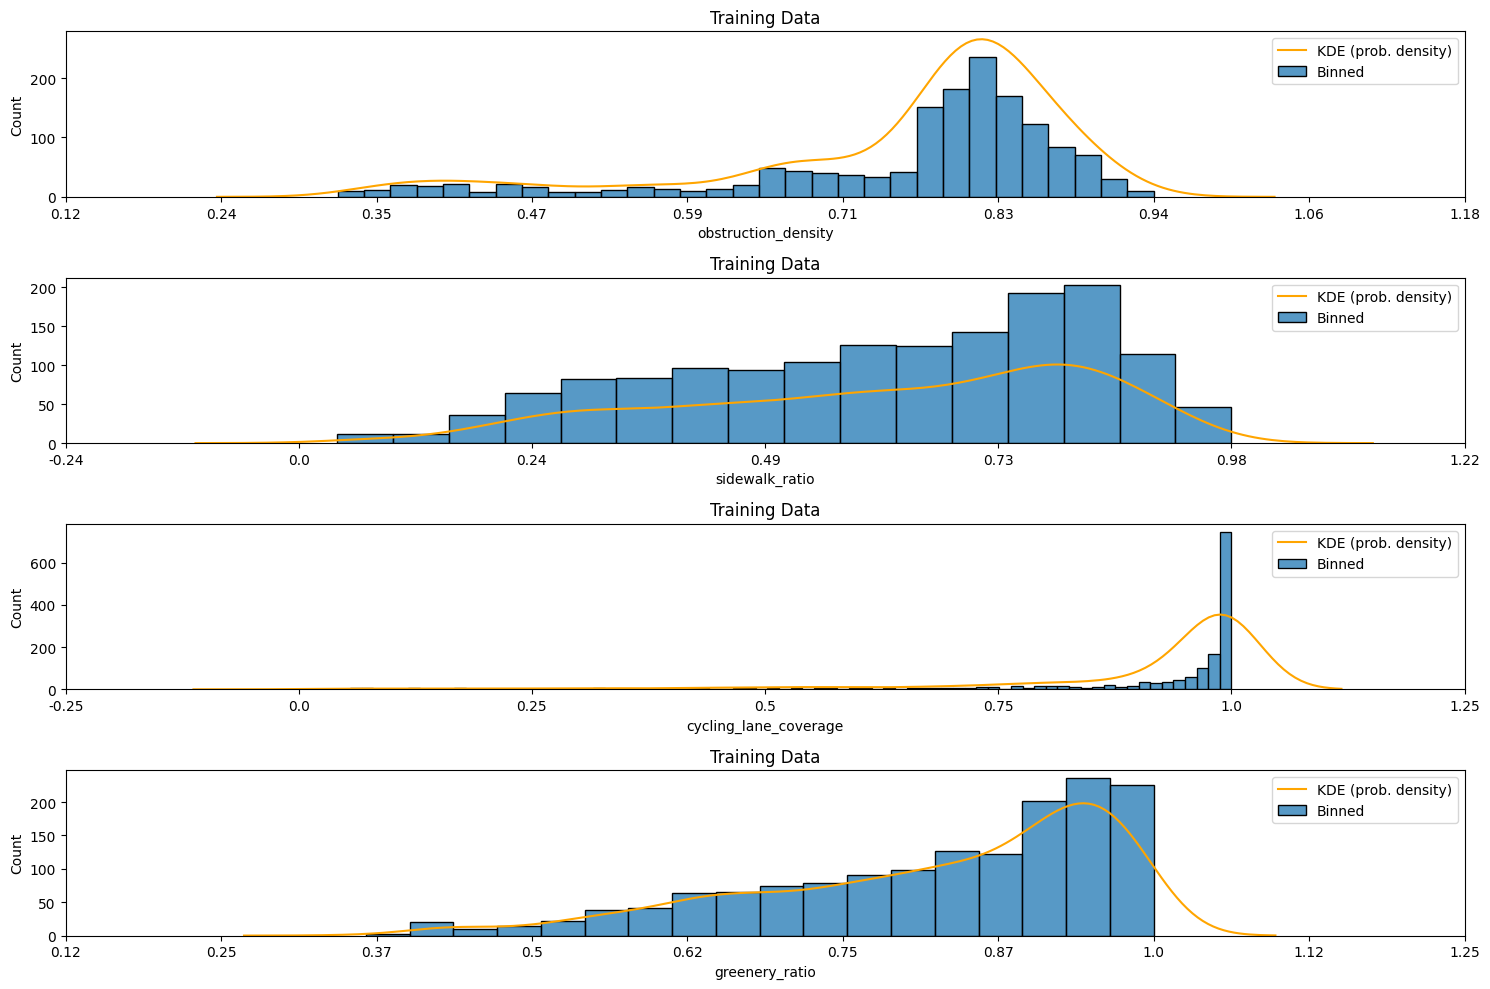

In [144]:
fig, axes = plt.subplots(len(num_vars), 1, figsize = (15, 10))
continuous_distributions(df_walk, axes[:], title = "Training Data")
plt.tight_layout()
plt.show()

In [145]:
df_walk_scaled = df_walk.copy()

In [146]:
# Scaling for continuous variables
df_walk_scaled['obstruction_density'] = np.log1p(df_walk['obstruction_density'])
df_walk_scaled['greenery_ratio'] = np.log1p(df_walk['greenery_ratio'])

standard_scaler = StandardScaler()
df_walk_scaled['sidewalk_ratio'] = standard_scaler.fit_transform(df_walk[['sidewalk_ratio']])

robust_scaler = RobustScaler()
df_walk_scaled['cycling_lane_coverage'] = robust_scaler.fit_transform(df_walk[['cycling_lane_coverage']])

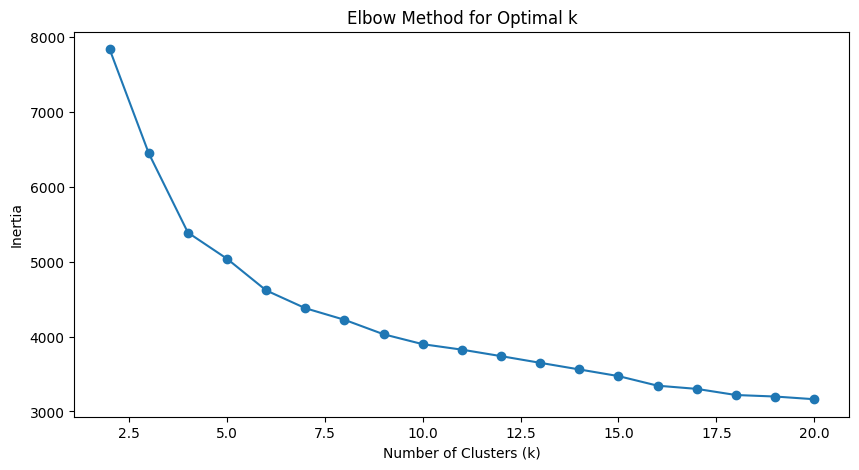

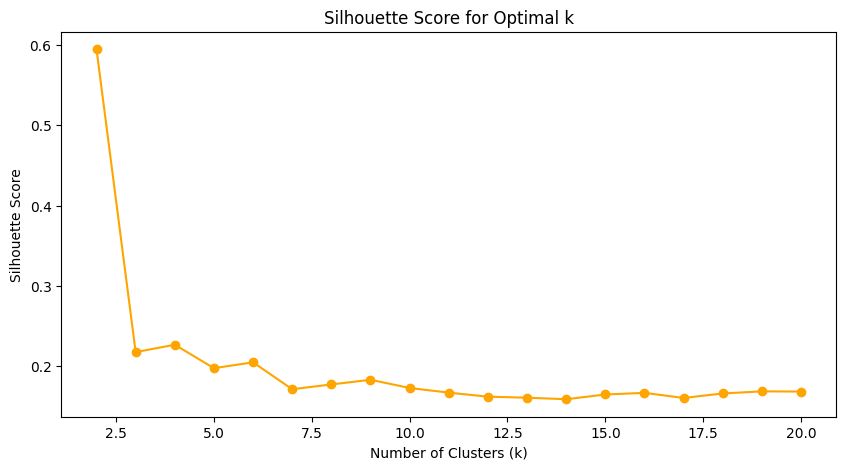

In [147]:
X = preprocessor.fit_transform(df_walk_scaled)

# Find optimal number of clusters
inertias, silhouette_scores = find_optimal_clusters(X, max_k=20)

In [148]:
clustered_df_walk, final_walk_pipeline = perform_kmeans_clustering(df_walk_scaled, chosen_k)

In [149]:
clustered_df_walk.head()

,has_crosswalk,has_traffic_sign,has_traffic_light,has_bicycle,obstruction_density,sidewalk_ratio,cycling_lane_coverage,greenery_ratio,road_condition,scene_label,highway,surface,Cluster
0,1.0,1.0,1.0,0.0,0.598624,-1.355945,-3.269839,0.584221,1.0,alley,footway,None,2
1,1.0,1.0,1.0,1.0,0.609971,-1.255854,-1.908977,0.573438,1.0,alley,footway,None,0
2,1.0,1.0,1.0,0.0,0.598624,-1.355945,-3.269839,0.584221,1.0,alley,footway,None,2
3,1.0,1.0,1.0,1.0,0.609971,-1.255854,-1.908977,0.573438,1.0,alley,footway,None,0
4,0.0,1.0,1.0,1.0,0.606253,1.126660,-3.223401,0.624115,1.0,street,service,concrete,2


# Export

In [150]:
df_bike_export = df_bike.drop(columns=['has_lit', 'highway', 'surface'])
df_bike_scaled_export = df_bike_scaled.drop(columns=['has_lit', 'highway', 'surface'])
df_walk_export = df_walk.drop(columns=['highway', 'surface'])
df_walk_scaled_export = df_walk_scaled.drop(columns=['highway', 'surface'])

In [151]:
df_bike_export.shape

(1514, 10)

In [153]:
df_bike_export = pd.concat([df_bike_export, bike_ids], axis=1)
df_bike_scaled_export1= pd.concat([df_bike_scaled_export, bike_ids], axis=1)
df_walk_export = pd.concat([df_walk_export, walk_ids], axis=1)
df_walk_scaled_export = pd.concat([df_walk_scaled_export, walk_ids], axis=1)

In [154]:
df_bike_export.to_csv('features/bike_features.csv', index=False)
df_bike_scaled_export.to_csv('features/bike_scaled_features.csv', index=False)
df_walk_export.to_csv('features/walk_features.csv', index=False)
df_walk_scaled_export.to_csv('features/walk_scaled_features.csv', index=False)

In [155]:
clustered_df_bike_export = pd.concat([clustered_df_bike, bike_ids], axis=1)
clustered_df_walk_export = pd.concat([clustered_df_walk, walk_ids], axis=1)

In [156]:
clustered_df_bike_export.to_csv('features/bike_cluster_full.csv', index=False)
clustered_df_walk_export.to_csv('features/walk_cluster_full.csv', index=False)

In [157]:
preprocessor.get_feature_names_out()

array(['cat__scene_label_alley', 'cat__scene_label_bridge',
       'cat__scene_label_crosswalk', 'cat__scene_label_driveway',
       'cat__scene_label_forest_road', 'cat__scene_label_highway',
       'cat__scene_label_railroad_track',
       'cat__scene_label_residential_neighborhood',
       'cat__scene_label_street', 'cat__highway_footway',
       'cat__highway_path', 'cat__highway_pedestrian',
       'cat__highway_primary', 'cat__highway_primary_link',
       'cat__highway_residential', 'cat__highway_secondary',
       'cat__highway_service', 'cat__highway_steps',
       'cat__highway_tertiary', 'cat__highway_trunk',
       'cat__highway_trunk_link', 'cat__highway_unclassified',
       'cat__surface_asphalt', 'cat__surface_concrete',
       'cat__surface_paving_stones', 'cat__surface_None',
       'remainder__has_crosswalk', 'remainder__has_traffic_sign',
       'remainder__has_traffic_light', 'remainder__has_bicycle',
       'remainder__obstruction_density', 'remainder__sidewalk_ra

In [161]:
test = pd.read_csv('features/bike_features.csv')

In [163]:
test

,has_crosswalk,has_traffic_sign,has_traffic_light,has_bicycle,obstruction_density,sidewalk_ratio,cycling_lane_coverage,greenery_ratio,road_condition,scene_label,u,v,key
0,1.0,1.0,1.0,0.0,0.819613,0.322586,0.750000,0.793593,1.0,alley,10148578463,10148578465,0
1,1.0,1.0,1.0,1.0,0.840378,0.343999,0.848252,0.774357,1.0,alley,10148578464,10148578465,0
2,1.0,1.0,1.0,0.0,0.819613,0.322586,0.750000,0.793593,1.0,alley,10148578465,10148578463,0
3,1.0,1.0,1.0,1.0,0.840378,0.343999,0.848252,0.774357,1.0,alley,10148578465,10148578464,0
4,0.0,1.0,1.0,1.0,0.833548,0.853715,0.753353,0.866594,1.0,street,10821751973,10821751974,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1509,0.0,1.0,1.0,1.0,0.768757,0.598447,0.996559,0.919328,1.0,alley,9985809971,242433511,0
1510,1.0,1.0,1.0,1.0,0.803046,0.976358,0.999013,0.632834,0.0,residential_neighborhood,9985849229,9985849233,0
1511,0.0,1.0,1.0,1.0,0.788574,0.893868,0.999474,0.611156,1.0,residential_neighborhood,9985849233,11664622846,0
1512,1.0,1.0,1.0,1.0,0.803046,0.976358,0.999013,0.632834,0.0,residential_neighborhood,9985849233,9985849229,0
